In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
fs = full_results[full_results['candidate'] == 'Felicia Singh']

ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

fs = gpd.GeoDataFrame(fs,geometry=fs['geometry'].apply(wkt.loads))
fs = fs.set_crs(epsg=2263, allow_override=True)
co_3857 = fs.to_crs(epsg=3857)

In [2]:
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

In [3]:
aal = pd.read_csv('../../cc_election_cleaning/precincts_leins.csv')

In [5]:
demo_occ = fs[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','prican21p','mex21p','white_transplant_ratio','adams213p','winda21p']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')
demo_occ = demo_occ.merge(aal[['ElectDist','tl_count']], on='ElectDist', how='left')

In [6]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [9]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p','prican21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop','tl_count','adams213p'] + wp_cols

In [10]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

KeyError: ['vote_share']

In [138]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.65150051 0.32576314 0.64417987 0.58086472 0.47815514 0.42007485
 0.09582038 0.36333493 0.27434393 0.27545949 0.50912945 0.33697751
 0.36524473 0.5552937  0.42428703 0.33804949 0.44201544 0.22814166
 0.38659782 0.09585209 0.36596408 0.51644422 0.1847659  0.24851107
 0.26355899 0.26409304 0.14415245 0.12954072 0.09792198 0.36550905
 0.15570698 0.13434928 0.41737448 0.08975438 0.17503043 0.18301654
 0.31680967 0.17643618 0.18431187 0.20475082 0.31202169 0.19412227
 0.41510374 0.41405643 0.12458473 0.22208366 0.24276048 0.30859658
 0.33820233 0.09525275]
Overall KMO: 0.30159295186511126
Bartlett’s test χ²: 5497.488913319383 p-value: 0.0


In [12]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [139]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'w2admp' (KMO=0.090); new overall KMO before recalculation = 0.302
Dropping 'w2aep' (KMO=0.090); new overall KMO before recalculation = 0.366
Dropping 'w2farmp' (KMO=0.103); new overall KMO before recalculation = 0.392
Dropping 'venez21p' (KMO=0.133); new overall KMO before recalculation = 0.425
Dropping 'w2banp' (KMO=0.162); new overall KMO before recalculation = 0.462
Dropping 'w2matp' (KMO=0.157); new overall KMO before recalculation = 0.494
Dropping 'w2cmp' (KMO=0.274); new overall KMO before recalculation = 0.515
Dropping 'w2prodp' (KMO=0.260); new overall KMO before recalculation = 0.526
Dropping 'w2ffp' (KMO=0.260); new overall KMO before recalculation = 0.560
Dropping 'filip21p' (KMO=0.260); new overall KMO before recalculation = 0.582
Dropping 'w2lawp' (KMO=0.325); new overall KMO before recalculation = 0.598
Dropping 'nhb21p' (KMO=0.371); new overall KMO before recalculation = 0.626
Dropping 'hh21bop' (KMO=0.368); new overall KMO before recalculation = 0.631
Dropping

In [140]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

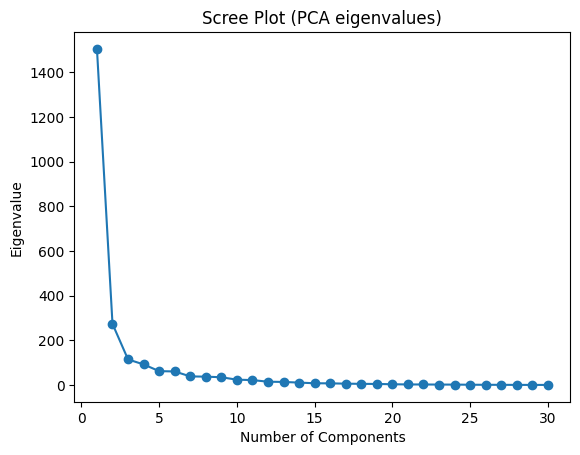

In [141]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [142]:
n_factors = 3
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [143]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [144]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1    Factor2   Factor3
nhw21p                 -24.437111  15.518638 -4.398390
h21p                     7.206629 -15.179254 -1.564979
nha21p                  14.406094   1.401628 -0.220414
cvap21bapp              -5.285568   4.081823 -1.850445
log_mhhi21               0.286807  -0.110359 -0.341868
chin21p                  1.207080  -1.089106 -1.352239
kor21p                  -0.048684   0.039260 -0.017659
colomb21p                0.480049  -1.198646 -0.771102
domin21p                 2.827469  -4.219576 -0.253683
prican21p                0.395700  -2.680476  1.364879
white_transplant_ratio  -0.943978   0.583263 -0.412543
ind21p                  10.234218   2.641065  1.810256
bang21p                  1.995142   0.385137 -0.646999
pak21p                   0.481053  -0.322818  0.073556
greek21p                -0.115014   0.045355 -0.036392
fb21bdp                  4.410720   1.148625 -1.253556
fb21drp                  1.058289  -2.350564 -0

In [145]:
Y = demo_occ['ge_vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:          ge_vote_share   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     80.53
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           7.01e-26
Time:                        16:53:03   Log-Likelihood:                -376.20
No. Observations:                  98   AIC:                             760.4
Df Residuals:                      94   BIC:                             770.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.2602      1.160     37.301      0.0

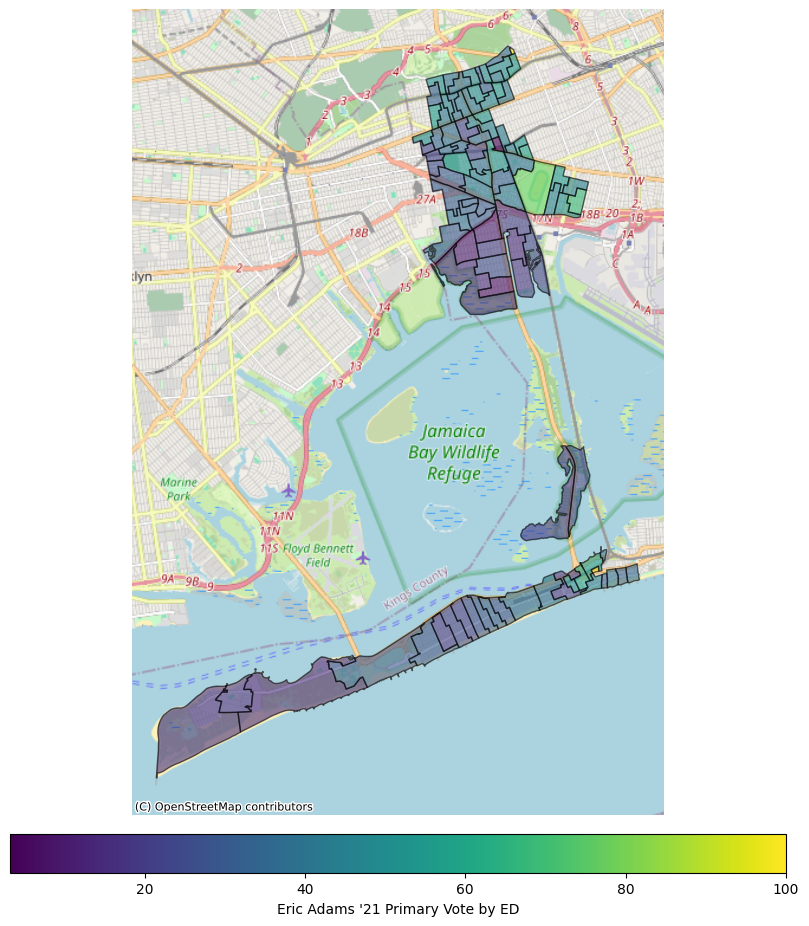

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
co_3857.plot(
    column="vote_share",
    legend=True,
    legend_kwds={
        "label": "Eric Adams '21 Primary Vote by ED",
        "orientation": "horizontal",
        "shrink": 0.8,        
        "pad": 0.02            
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [22]:
eth_cols = ['ind21p','bang21p','domin21p','venez21p','mex21p','white_transplant_ratio','winda21p','colomb21p','chin21p',
            'kor21p']
red_eth_cols = ['nhw21p','nhb21p','h21p','nha21p']

In [23]:
demo_occ_map = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry_x'].apply(wkt.loads))
gdf = demo_occ_map.copy()

In [24]:
gdf = demo_occ_map.copy()

In [25]:
gdf['laptop'] = gdf['w2admp'] + gdf['w2banp'] + gdf['w2cmp']

In [26]:
gdf['laptop'] = gdf['w2admp'] + gdf['w2banp'] + gdf['w2cmp']

gdf['dom_eth']   = gdf[eth_cols].idxmax(axis=1)  
gdf['dom_eth_p'] = gdf[eth_cols].max(axis=1)     

gdf['dom_red_eth']   = gdf[red_eth_cols].idxmax(axis=1)
gdf['dom_red_eth_p'] = gdf[red_eth_cols].max(axis=1)

gdf['dom_occ']   = gdf[wp_cols].idxmax(axis=1)
gdf['dom_occ_p'] = gdf[wp_cols].max(axis=1)

In [27]:
gdf = gdf.set_crs(epsg=2263, allow_override=True)
gdf_3857 = gdf.to_crs(epsg=3857)

In [28]:
occ_label_map = {
    'w2admp': 'Designers & Journalists',
    'w2banp': 'Analyst Specialist',
    'w2bgp': 'Janitorial',
    'w2conp': 'Construction',
    'w2copp': 'Law Enforcement',
    'w2foodp': 'Food Service',
    'w2hsp': 'Homecare',
    'w2mgtp': 'Management',
    'w2oadp': 'Office Admin',
    'w2salep': 'Sales'
}

gdf_3857['occupation_label'] = gdf_3857['dom_occ'].map(occ_label_map)
gdf_3857['occupation_label'] = gdf_3857['occupation_label'].astype('category')

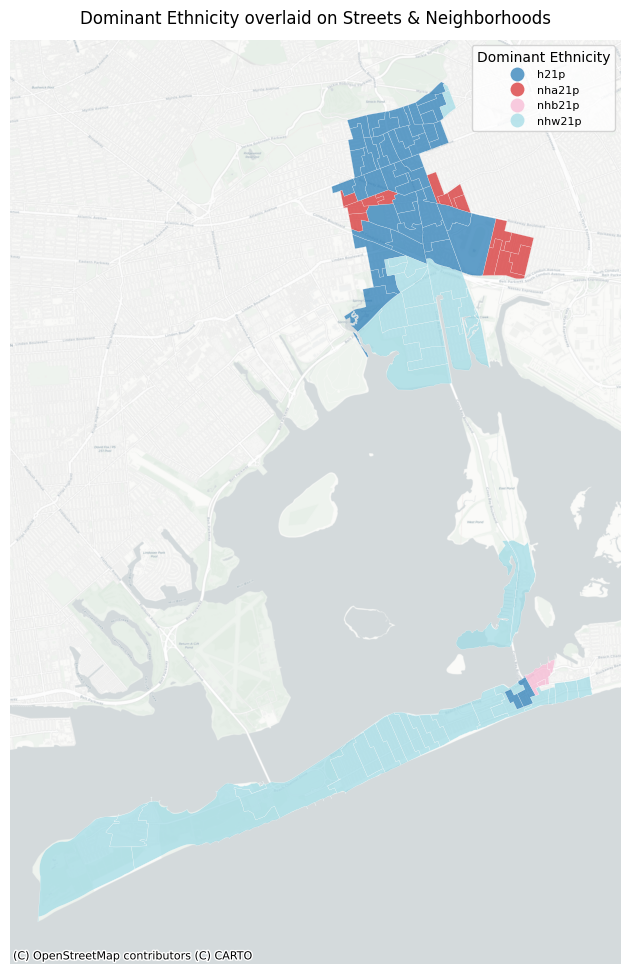

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_3857.plot(
    column='dom_red_eth',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)


ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

# 5) Clean up
ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()

In [53]:
filepath = '../data/thirty_second.csv'

In [55]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

In [ ]:
def import_clean(filepath,good_cols,colnames):
    df = pd.read_csv(filepath,header=None, names=colnames)
    df = df[good_cols]
    df['precinct'] = 'AD: ' + df['AD'].astype(str) + ' ' + 'ED: ' + df['ED'].astype(str).str.zfill(3)
    df['ed_name'] = df['AD'].astype(str) + df['ED'].astype(str).str.zfill(3)
    return df

def rearrange(df,candidates):
    df = df[df['edited_candidate'].isin(candidates)]
    df = df[['precinct','ed_name','edited_candidate','Tally']]
    df.columns = ['precinct','ed_name','candidate','votes']
    df = df.groupby(['ed_name','candidate'])['votes'].sum().reset_index()
    df['ed_total'] = df.groupby('ed_name')['votes'].transform('sum')
    df['vote_share'] = round(df['votes'] / df['ed_total'] * 100,2)
    df['vote_share'] = pd.to_numeric(df['vote_share'], errors='coerce')
    return df

In [105]:
def rearrange(df,candidates):
    df = df[df['edited_candidate'].isin(candidates)]
    df = df[['precinct','ed_name','edited_candidate','Tally']]
    df.columns = ['precinct','ed_name','candidate','votes']
    df = df.groupby(['ed_name','candidate'])['votes'].sum().reset_index()
    df['ed_total'] = df.groupby('ed_name')['votes'].transform('sum')
    df['vote_share'] = round(df['votes'] / df['ed_total'] * 100,2)
    df['vote_share'] = pd.to_numeric(df['vote_share'], errors='coerce')
    return df


In [111]:
ge = import_clean(filepath,good_cols,colnames)

In [112]:
ja = ['Joann Ariola (Republican/Save Our City)','Joann Ariola (Conservative)']
fel = ['Felicia Singh (Democratic)']

In [113]:
ge['edited_candidate'] = 'Unknown'
ge.loc[ge['Unit Name'].isin(ja), 'edited_candidate'] = 'Joann Ariola'
ge.loc[ge['Unit Name'].isin(fel), 'edited_candidate'] = 'Felicia Singh'

In [114]:
candidates = ['Felicia Singh','Joann Ariola']

In [115]:
ge = rearrange(ge,candidates)

In [119]:
ge_fs = ge[ge['candidate'] == 'Felicia Singh']

In [121]:
ge_fs = ge_fs[['ed_name','vote_share']]

In [122]:
ge_fs.columns = ['ed_name','ge_vote_share']

In [126]:
ge_fs['ed_name'] = ge_fs['ed_name'].astype('Int64')

C:\Users\samtg\AppData\Local\Temp\ipykernel_26128\2986345886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ge_fs['ed_name'] = ge_fs['ed_name'].astype('Int64')


In [128]:
co_3857 = co_3857.merge(ge_fs,on='ed_name')

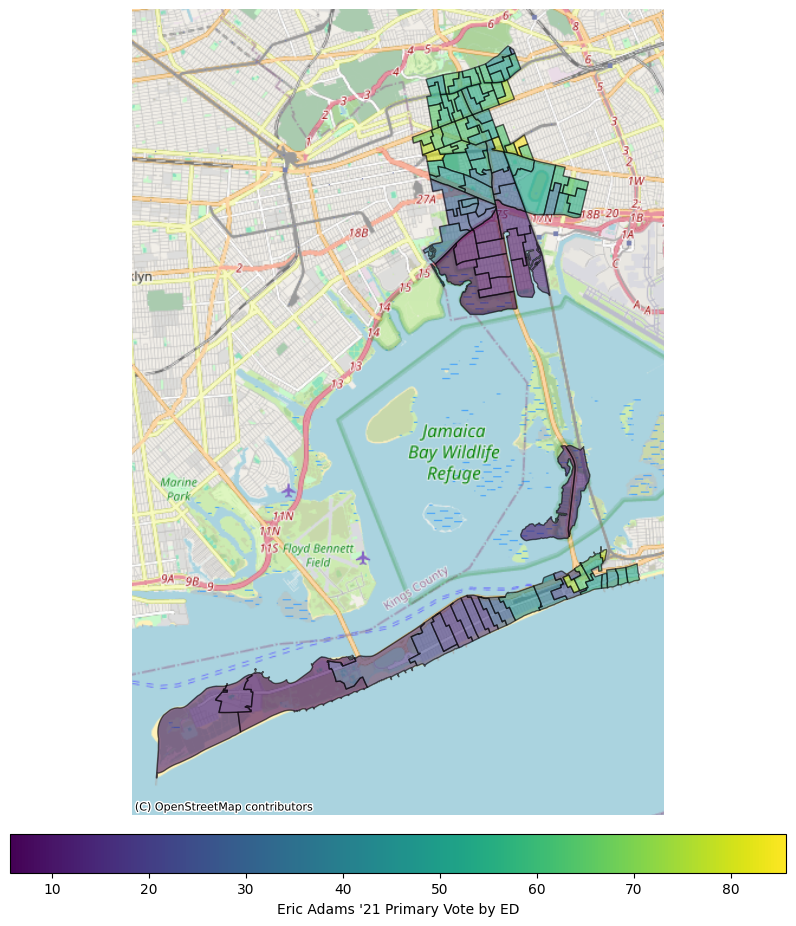

In [129]:
fig, ax = plt.subplots(figsize=(10, 10))
co_3857.plot(
    column="ge_vote_share",
    legend=True,
    legend_kwds={
        "label": "Eric Adams '21 Primary Vote by ED",
        "orientation": "horizontal",
        "shrink": 0.8,        
        "pad": 0.02            
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [132]:
demo_occ = demo_occ.merge(ge_fs,on='ed_name')

In [148]:
test_cols = ['diff','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p','prican21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop','tl_count','adams213p'] + wp_cols

In [149]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('diff'),inplace=True)
cor_matrix.sort_values(by='diff', ascending=False)

,diff,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,log_mhhi21,venez21p,chin21p,kor21p,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
diff,1.000000,-0.545997,0.207615,0.361695,0.490542,-0.312487,0.136699,-0.031429,0.216641,-0.234623,...,0.266570,0.280906,0.190494,0.144856,-0.015153,0.015018,0.106201,0.082822,0.388156,-0.039711
bang21p,0.607795,-0.412410,-0.123134,0.183305,0.668900,-0.204262,0.233803,-0.045777,0.137107,-0.183953,...,0.278217,0.142522,0.282913,0.168857,-0.078040,-0.108269,0.254587,0.052333,0.363327,-0.135515
fb21bdp,0.504191,-0.423113,-0.125324,0.154130,0.725043,-0.232167,0.229974,-0.036459,0.228811,-0.171477,...,0.267120,0.099403,0.413861,0.157120,-0.025638,-0.134145,0.264704,0.011491,0.351167,-0.101088
w2foodp,0.502578,-0.401964,-0.092963,0.384740,0.349084,-0.232454,0.288528,0.130244,0.518404,-0.134973,...,0.177846,0.153394,0.042551,0.258537,0.508876,0.006306,-0.002419,-0.065536,0.137437,0.178254
nha21p,0.490542,-0.756172,-0.072620,0.332474,1.000000,-0.474698,0.372430,0.007498,0.356331,-0.357910,...,0.457954,0.346156,0.585392,0.443644,0.008338,-0.012335,0.534878,0.110067,0.355864,-0.003941
domin21p,0.441570,-0.751723,0.042106,0.856265,0.412644,-0.515576,0.306454,0.318362,0.370752,-0.404690,...,0.495698,0.203044,0.233299,0.261851,0.057869,0.253610,0.179236,0.148232,0.485544,-0.158848
pak21p,0.400800,-0.405235,-0.105212,0.407879,0.360219,-0.335965,0.197729,0.067381,-0.067076,-0.179504,...,0.175299,0.445562,0.286356,0.241011,-0.101660,0.202408,0.278368,0.305008,0.321424,-0.047944
ind21p,0.398590,-0.653279,-0.004168,0.164101,0.934060,-0.407374,0.322852,-0.042649,0.119264,-0.272539,...,0.353930,0.309627,0.652728,0.377875,-0.085205,-0.032224,0.537516,0.173246,0.278125,0.037175
w2hsp,0.396489,-0.542709,0.417114,0.420008,0.258026,-0.269587,-0.050821,-0.091135,0.095928,-0.287500,...,0.311268,0.210525,0.236240,0.004309,0.014937,-0.032173,0.228811,0.044410,0.389810,-0.032114
w2tranp,0.388156,-0.532893,0.148450,0.528849,0.355864,-0.442458,0.145356,-0.046787,0.175336,-0.390272,...,0.308322,0.096708,0.112787,0.226550,-0.092486,0.192619,0.285413,0.205031,1.000000,0.025037


In [146]:
demo_occ['diff'] = demo_occ['ge_vote_share'] - demo_occ['vote_share']

In [147]:
demo_occ[['diff','vote_share','ge_vote_share']].describe()

,diff,vote_share,ge_vote_share
count,98.000000,98.000000,98.000000
mean,6.338508,36.921696,43.260204
std,19.275341,14.970830,21.355141
min,-73.680000,3.225806,5.670000
25%,-6.527698,26.936709,25.540000
50%,3.735591,36.650165,48.825000
75%,16.994676,45.371397,60.385000
max,74.894194,100.000000,85.710000
